## Unet workflow
Important thing to note is that the Change Detection model's performance is related to the classifications model's performance. The better our model can learn via supervised learning, the better it will perform in the unsupervised change detection task.

Explain purpose of this notebook and prerequisits (data processing and directory structure)



- Unsupervised change detection with u-net: https://arxiv.org/abs/1812.05815

- unet attention https://arxiv.org/abs/1804.03999

- unet attention https://ieeexplore.ieee.org/abstract/document/8964956

- residual attention unet https://arxiv.org/abs/1909.10360

In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, concatenate, multiply, Lambda, LeakyReLU
from tensorflow.keras import backend as kb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import segmentation_models as sm
from segmentation_models.losses import categorical_focal_jaccard_loss
from segmentation_models.metrics import iou_score
#from keras_segmentation.models.unet import vgg_unet
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

### Visualize some of the data

In [2]:
os.getcwd()

'/home/jovyan/opt/SemanticSeg'

In [3]:
os.chdir('/home/jovyan/opt/SemanticSeg/')

In [4]:
os.getcwd()

'/home/jovyan/opt/SemanticSeg'

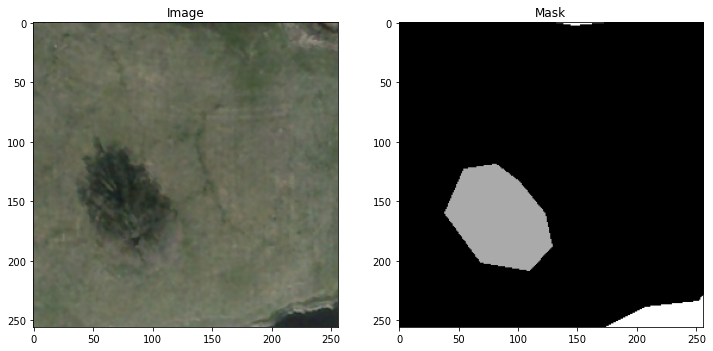

In [5]:
train_img_dir = os.path.join(os.getcwd(), 'data', '256_patches', 'images')
train_mask_dir = os.path.join(os.getcwd(), 'data', '256_patches', 'masks')

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(os.path.join(train_img_dir, img_list[img_num]), 1)

img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
mask_for_plot =cv2.imread(os.path.join(train_mask_dir, msk_list[img_num]), 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [6]:
# number of classes present in the mask
to_categorical(mask_for_plot, 5).shape


(256, 256, 5)

## Data Generator/Data Preprocessing

Here we create the training data generator and the validation data generator so that we can pull batches of images from our directories. Also, we define a preprocessing function which we are able to apply to each batch of data that is generated which prepares it to be sent through out deep learning model. One of the preprocessing steps which is required regardless of the model architecture is the normalization of the pixel values which is completed here by calling the minimax scaler function from scikit-learn. (setting each value to be either between -1, 1 or another approach is to set them between 0,1)

In [7]:
seed=24
batch_size= 16
scaler = MinMaxScaler()

def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    # applies preprocessing to each batch of generated images
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


## Supervised training of Unet for semantic classification

Here we are training our unet via supervised learning by taking tiled satellite imagery which comes with a ground truth target masking. I have chosen to use data generators to feed the model so that the model can pull batches of images to be fed into the model and does not pull all of the images at one time. 

Large scale deployment of this model is possible: one idea is to train a u-net model on a large labeled data set and then deploy instances of this trained model to each region of interest. The instances are then fine-tuned on a smaller data set that is specific to that actual region thus improving each models performance and allowing for each region to have its own specific version of the main model. The fine tuning processes consists of taking the initially trained model, freezing the majority of the beggining layers and then slowly (with a very low learning rate) re-training the model on the dataset with region specific data. (look into transfer learning methods for deep neural networks to gain a deeper technical understanding).

In [8]:
train_img_path = os.path.join(os.getcwd(), 'data', 'train_val_data', 'train_images')
train_mask_path = os.path.join(os.getcwd(), 'data', 'train_val_data', 'train_masks')
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

val_img_path = os.path.join(os.getcwd(), 'data', 'train_val_data', 'val_images')
val_mask_path = os.path.join(os.getcwd(), 'data', 'train_val_data', 'val_masks')
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

Found 37481 images belonging to 2 classes.
Found 37481 images belonging to 2 classes.


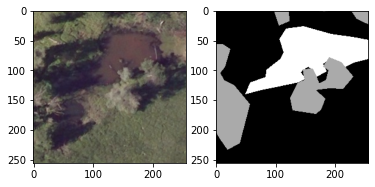

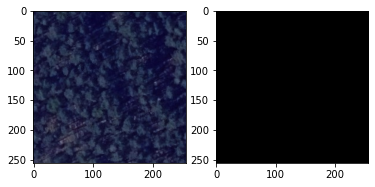

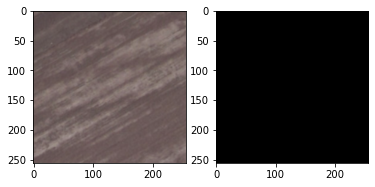

In [9]:
x, y = train_img_gen.__next__()

# testing training generator
for i in range(13,16):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

    
    

Found 4165 images belonging to 2 classes.
Found 4165 images belonging to 2 classes.


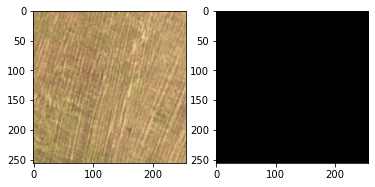

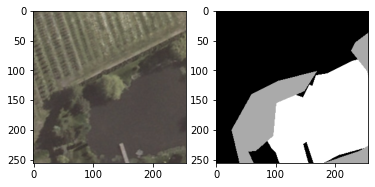

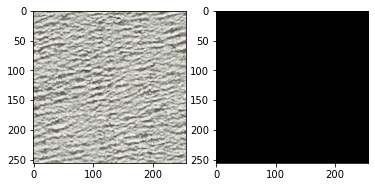

In [10]:
x_val, y_val = val_img_gen.__next__()
# testing validation generator    
for i in range(13,16):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [11]:
#Define the model metrcis and load model. 
num_train_imgs = len(os.listdir(os.path.join(os.getcwd(), 'data', 'train_val_data', 'train_images', 'train')))
num_val_images = len(os.listdir(os.path.join(os.getcwd(), 'data', 'train_val_data', 'val_images', 'val')))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

In [12]:
print("Number of training images:",num_train_imgs)
print("Number of validation images:",num_val_images)

Number of training images: 37481
Number of validation images: 4165


## Building the Model

Below I am building the traditional u-net model without any added attention or residual connections. There are a few u-net architectures that I think would perform really well on sattellite data, one of which implements channel wise attention (band attention where it creates activation weights for the spectral bands of the image and gives them levels of importance when making the final classification) and also spatial attention, which allows the network to learn where to "look" within the image to find the most meaningful information.

The conv_block and encoder_block used in building the u-net are the same that we used to build the autoencoder, the only difference is the decoder block which we define below.

### U-net (traditional)

In [2]:
def conv_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Convolutional Block
    
    Arguments:
        inputs - input tensor usually image shape (x, x, 3)
        n_filters - number of filters for conv layers
        dropout_prob - dropout probability (added for model regularization)
        
    Performs 2 convolutional steps with kernel size (3,3) stride 1 followed by batch normalization and or dropout depending
    on parameter sepcifications
    
    Returns:
        conv_layer 
        
    """
    act_fn = LeakyReLU(alpha=0.2)
    
    # first conv layer
    conv1 = Conv2D(n_filters, 3, padding='same')(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 2nd conv layer
    conv2 = Conv2D(n_filters, 3, padding='same')(conv1)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    
    # adding Dropout 
    if dropout_prob > 0:
        conv2 = Dropout(dropout_prob)(conv2)
    
    return conv2

In [3]:
def encoder_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Encoder Block (downsampling)
    
    Applies max pooling (2,2) to downsample the input conv_block and return skip connection and next layer input
    
    Arguments:
    Inherits the parameters from the input conv_block
    
        inputs - output of conv_block 
        n_filters - number of filters to applied to conv_block
        dropout_prob - probability of dropout
    
    Returns:
        next_layer, skip connection
    """
    
    skip_connection = conv_block(inputs, n_filters, batch_norm, dropout_prob)
    next_layer = MaxPooling2D((2,2))(skip_connection)
    
    return next_layer, skip_connection

In [4]:
def decoder_block(expansive_input, contractive_input, n_filters=64, batch_norm=False, dropout_prob=0):
    
    """
    Convolutional Upsampling Block
    
    Apply Conv2DTranspose stride 2 or Upsampling2D to upsample lower level feature embeddings spatially to the same dimensions
    as the skip_connections for concatenation, concatenate them, pass them through normally convolutional block,
    then return the output to be used as the input for the next upsampling block in the model
    
    Arguments:
        expansive_input - Input tensor from previous layer
        contractive_input - Input tensor from previous skip layer (skip_connection)
        
    Returns:
        conv - Tensor
    """
    
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    
    # merge upsampled input with skip connection
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = conv_block(merge, n_filters, batch_norm, dropout_prob)
    
    return conv

In [5]:
def unet_model(input_size=(256, 256, 3), n_filters=64, n_classes=5, batch_norm=True):
    
    """
    U-net Model
    
    Arguments:
        input_size: size of input image (often in preprocess we tile the original sattelite image to a smaller scale)
        n_filters: number of filters (feature maps or kernels) for conv layers 
        n_classes: number of target classes
        
    Return:
        model - tf.keras.model
    """
    inputs = Input(input_size)
    
    # encoder
    # Double the number of filters at each time step
    
    enc_block1 = encoder_block(inputs, n_filters, batch_norm)
    
    enc_block2 = encoder_block(enc_block1[0], n_filters*2, batch_norm)
    
    enc_block3 = encoder_block(enc_block2[0], n_filters*4, batch_norm)
    
    enc_block4 = encoder_block(enc_block3[0], n_filters*8, batch_norm, dropout_prob=0.3)
    
    # conv block instead of encoder block (Bridge)
    bridge = conv_block(enc_block4[0], n_filters*16, batch_norm, dropout_prob=0.3)
    
    
    # decoder      
            
    # chain the output of the previous block as expansive_input and the corresponding contractive block output
    # use half number of filters at each time step
    
    dec_block4 = decoder_block(bridge, enc_block4[1], n_filters*8, batch_norm)
    
    dec_block3 = decoder_block(dec_block4, enc_block3[1], n_filters*4, batch_norm)
    
    dec_block2 = decoder_block(dec_block3, enc_block2[1], n_filters*2, batch_norm)
    
    dec_block1 = decoder_block(dec_block2, enc_block1[1], n_filters, batch_norm)
    
    # output tensor with number of channels based on number of target classes
    conv10 = Conv2D(n_classes, 1, padding='same', activation='softmax')(dec_block1)

    # create model object
    model = tf.keras.Model(inputs=inputs, outputs=conv10, name='U-net')
    
    return model

In [17]:
# unet = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), n_filters=64,
#                   n_classes=5, batch_norm=True)
# #unet.summary()

In [18]:
# unet.compile(optimizer=Adam(learning_rate=1e-4), loss=categorical_focal_jaccard_loss, metrics=[iou_score])

## Train the model

Some things to add to this would be 
- maybe some more regularization
- learning rate decay with a scheduler

In [19]:
def get_compiled_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), n_filters=64,
                  n_classes=5, batch_norm=True)
    model.compile(
        optimizer=Adam(learning_rate=1e-4), 
        loss=categorical_focal_jaccard_loss, 
        metrics=[iou_score]
    )
    return model


# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return tf.keras.models.load_model(latest_checkpoint, custom_objects={'iou_score': iou_score, 'focal_loss_plus_jaccard_loss':sm.losses.categorical_focal_jaccard_loss})
    print("Creating a new model")
    return get_compiled_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


def run_training(epochs=1):

   
    model = make_or_restore_model()

    callbacks = [
        # This callback saves a SavedModel every epoch
        # We include the current epoch in the folder name.
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/landcover-0001-ckpt-{epoch}", save_freq="epoch"
        )
    ]
    model.fit(
          train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
        callbacks=callbacks
    )



### Metrics Explanation
- https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

### Checkpoints the model after every epoch

In [21]:
# Running the first time creates the model
#run_training(epochs=5)


In [20]:
train_loss = [0.6302, 0.5011, 0.4569, 0.4298, 0.4142, 0.4005, 0.3887, 0.3768, 0.3712, 0.3619, 0.3601, 0.3532,
              0.3463, 0.3432, 0.3369, 0.3365, 0.3324, 0.3260, 0.3238, 0.3210]
train_iou = [0.4075, 0.5255, 0.5669, 0.5921, 0.6068, 0.6192, 0.6303, 0.6415, 0.6467, 0.6555, 0.6570, 0.6634,
             0.6699, 0.6728, 0.6788, 0.6788, 0.6829, 0.6889, 0.6910, 0.6936]

val_loss = [0.6041, 0.5161, 0.5372, 0.5391, 0.4379, 0.4375, 0.4304, 0.4086, 0.3967, 0.3867, 0.4537, 0.4164,
            0.3974, 0.3865, 0.3810, 0.3809, 0.3915, 0.3761, 0.3574, 0.3831]
val_iou = [0.4291, 0.5144, 0.4936, 0.5031, 0.5834, 0.5830, 0.5901, 0.6115, 0.6214, 0.6298, 0.5688, 0.6022,
           0.6218, 0.6297, 0.6353, 0.6351, 0.6284, 0.6405, 0.6576, 0.6343]

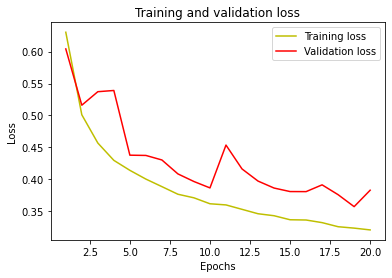

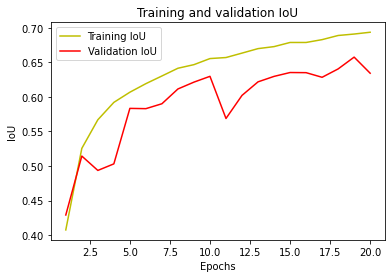

In [21]:
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, train_iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
# history = unet.fit(train_img_gen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=25,
#           validation_data=val_img_gen,
#           validation_steps=val_steps_per_epoch)

# model.save('landcover_25_epochs_0001.hdf5')

In [ ]:
# #plot the training and validation IoU and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['iou_score']
# val_acc = history.history['val_iou_score']

# plt.plot(epochs, acc, 'y', label='Training IoU')
# plt.plot(epochs, val_acc, 'r', label='Validation IoU')
# plt.title('Training and validation IoU')
# plt.xlabel('Epochs')
# plt.ylabel('IoU')
# plt.legend()
# plt.show()

## Making predictions with trained model


In [22]:
#calculate mean IoU on validation data set
model = load_model('ckpt/dckpt-19-landcover-0001', custom_objects={'iou_score': iou_score}, compile=False)

In [23]:
#Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 5
IOU_keras = tf.keras.metrics.MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.78550607


### Visualize predictions

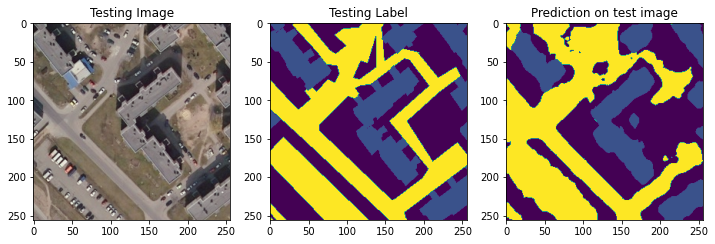

In [31]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()